<a href="https://colab.research.google.com/github/Giovanni-LN/Projeto_RN/blob/main/2__Rede_EfficientNet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar e preparar o Dataset

RandomRotation = 20

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho para o dataset no Google Drive
data_dir = "/content/drive/MyDrive/MyFoodDataset"

# Transformações para normalização e Data Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Flip horizontal aleatório
        transforms.RandomRotation(20),      # Rotação aleatória
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Normalização
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Carregar as imagens
image_datasets = {
    x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
    for x in ['train', 'val', 'test']
}

# Criar DataLoaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val', 'test']
}

# Verificar as classes
class_names = image_datasets['train'].classes
print("Classes detectadas:", class_names)

# Testar carregamento de um batch
images, labels = next(iter(dataloaders['train']))
print("Tamanho do batch:", images.shape)


Mounted at /content/drive
Classes detectadas: ['apple', 'bean', 'boiled', 'chicken', 'fried', 'lunch', 'rice', 'salad', 'spaghetti', 'steak']
Tamanho do batch: torch.Size([32, 3, 224, 224])


# Mapear as Classes

In [ ]:
class_mapping = {
    'apple': 'Maçã',
    'bean': 'Feijão',
    'boiled': 'Ovo Cozido',
    'chicken': 'Peito de Frango',
    'fried': 'Ovo Frito',
    'lunch': 'Almoço',
    'rice': 'Arroz',
    'salad': 'Salada',
    'spaghetti': 'Macarrão',
    'steak': 'Carne Assada'
}

# Criar a lista de classes traduzidas
filtered_class_names = [class_mapping[cls] for cls in class_names]
print("Classes finais mapeadas:", filtered_class_names)


Classes finais mapeadas: ['Maçã', 'Feijão', 'Ovo Cozido', 'Peito de Frango', 'Ovo Frito', 'Almoço', 'Arroz', 'Salada', 'Macarrão', 'Carne Assada']


# Verificar se os dados carregados e o mapeamento das classes estão funcionando.

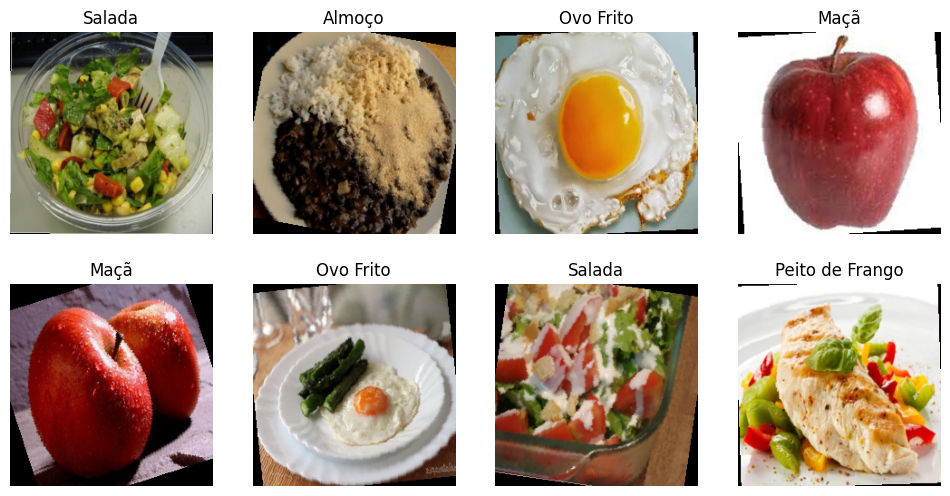

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Função para mostrar um batch de imagens
def imshow(inp, title=None):
    """Imprime uma imagem do tensor"""
    inp = inp.numpy().transpose((1, 2, 0))  # Ajusta para formato correto (Altura, Largura, Canais)
    mean = np.array([0.5, 0.5, 0.5])  # Valores usados na normalização
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean  # Desfaz a normalização
    inp = np.clip(inp, 0, 1)  # Garante que os valores estão no intervalo [0,1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

# Pegar um batch do dataloader de treino
inputs, labels = next(iter(dataloaders['train']))

# Criar grid com algumas imagens
fig = plt.figure(figsize=(12, 6))
for i in range(8):  # Exibir 8 imagens
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    imshow(inputs[i])
    ax.set_title(filtered_class_names[labels[i].item()])  # Nome traduzido da classe

plt.show()


# Carregar o modelo EfficientNet-B0 pré-treinado

Optmizer = SGD

Momentum = 0.9

Dropout = 0.3

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt

# Definir o dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar o modelo EfficientNet-B0 pré-treinado
model_effnet = models.efficientnet_b0(pretrained=True)  # ATIVADO
num_classes = 10

# Adicionando Dropout ao classificador do EfficientNet-B0
model_effnet.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model_effnet.classifier[1].in_features, num_classes)
)
model_effnet = model_effnet.to(device)

# Definir função de perda e otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_effnet.parameters(), lr=0.001, momentum=0.9)


Usando dispositivo: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 132MB/s]


# Função de Treinamento EfficientNet-B0

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=30):
    for epoch in range(num_epochs):
        print(f"\n Época {epoch+1}/{num_epochs}")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

            epoch_loss = running_loss / total
            epoch_acc = correct.double() / total
            print(f"{phase} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
    return model


# Executar o Treinamento EfficientNet-B0

In [ ]:
model_effnet = train_model(model_effnet, dataloaders, criterion, optimizer, num_epochs=30)


 Época 1/30
train | Loss: 2.2268 | Acc: 0.2027
val | Loss: 2.0130 | Acc: 0.4800

 Época 2/30
train | Loss: 1.8548 | Acc: 0.5707
val | Loss: 1.6432 | Acc: 0.7280

 Época 3/30
train | Loss: 1.4829 | Acc: 0.7560
val | Loss: 1.2546 | Acc: 0.8440

 Época 4/30
train | Loss: 1.1028 | Acc: 0.8533
val | Loss: 0.9335 | Acc: 0.8840

 Época 5/30
train | Loss: 0.8431 | Acc: 0.9027
val | Loss: 0.7018 | Acc: 0.9160

 Época 6/30
train | Loss: 0.6444 | Acc: 0.9107
val | Loss: 0.5559 | Acc: 0.9240

 Época 7/30
train | Loss: 0.4932 | Acc: 0.9293
val | Loss: 0.4801 | Acc: 0.9320

 Época 8/30
train | Loss: 0.4258 | Acc: 0.9427
val | Loss: 0.3939 | Acc: 0.9400

 Época 9/30
train | Loss: 0.3452 | Acc: 0.9453
val | Loss: 0.3257 | Acc: 0.9440

 Época 10/30
train | Loss: 0.3116 | Acc: 0.9467
val | Loss: 0.3096 | Acc: 0.9480

 Época 11/30
train | Loss: 0.2593 | Acc: 0.9587
val | Loss: 0.2733 | Acc: 0.9480

 Época 12/30
train | Loss: 0.2151 | Acc: 0.9760
val | Loss: 0.2450 | Acc: 0.9520

 Época 13/30
train | Los

# Avaliação do Modelo no Conjunto de Teste EfficientNet-B0

In [ ]:
def mc_dropout_evaluate(model, dataloader, criterion, device, num_runs=30):
    model.train()  # Ativa o Dropout mesmo na inferência!
    all_accuracies = []
    all_losses = []

    with torch.no_grad():
        for _ in range(num_runs):
            running_loss = 0.0
            correct = 0
            total = 0

            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                correct += torch.sum(preds == labels.data)
                total += labels.size(0)

            acc = correct.double() / total
            avg_loss = running_loss / total

            all_accuracies.append(acc.cpu().item())
            all_losses.append(avg_loss)

    mean_acc = np.mean(all_accuracies)
    std_acc = np.std(all_accuracies)

    mean_loss = np.mean(all_losses)
    std_loss = np.std(all_losses)

    return mean_acc, std_acc, mean_loss, std_loss


# Cálculo da Média e Desvio Padrão da Acurácia EfficientNet-B0



In [ ]:
num_runs = 5  # Número de execuções
accuracies = []

for i in range(num_runs):
    mean_acc, std_acc, mean_loss, std_loss = mc_dropout_evaluate(model_effnet, dataloaders['test'], criterion, device)

    accuracies.append(mean_acc)

    print(f"Execução {i+1}/{num_runs} | Loss: {mean_loss:.4f} ± {std_loss:.4f} | Acc: {mean_acc:.4f} ± {std_acc:.4f}")


mean_acc, std_acc, mean_loss, std_loss = mc_dropout_evaluate(model_effnet, dataloaders['test'], criterion, device)

print(f"MC Dropout Test Loss: {mean_loss:.4f} ± {std_loss:.4f}")
print(f"MC Dropout Test Acc: {mean_acc:.4f} ± {std_acc:.4f}")


Execução 1/5 | Loss: 0.2435 ± 0.0232 | Acc: 0.9279 ± 0.0123
Execução 2/5 | Loss: 0.2474 ± 0.0155 | Acc: 0.9292 ± 0.0090
Execução 3/5 | Loss: 0.2509 ± 0.0230 | Acc: 0.9271 ± 0.0111
Execução 4/5 | Loss: 0.2408 ± 0.0222 | Acc: 0.9300 ± 0.0090
Execução 5/5 | Loss: 0.2442 ± 0.0241 | Acc: 0.9296 ± 0.0109
MC Dropout Test Loss: 0.2493 ± 0.0224
MC Dropout Test Acc: 0.9256 ± 0.0114


# Matriz de confusão normalizada EfficientNet-B0

A matriz de confusão mostra o desempenho do modelo ao comparar as previsões com os valores reais.

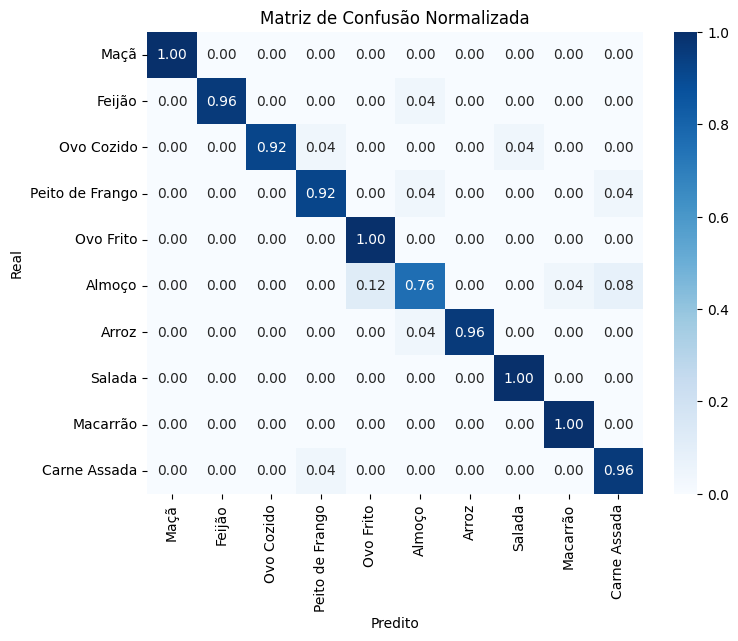

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch

# Lista correta das classes traduzidas
class_names = ['Maçã', 'Feijão', 'Ovo Cozido', 'Peito de Frango', 'Ovo Frito',
               'Almoço', 'Arroz', 'Salada', 'Macarrão', 'Carne Assada']

def plot_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Gerar matriz de confusão
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão Normalizada")
    plt.show()

# Chamar a função
plot_confusion_matrix(model_effnet, dataloaders['test'], device, class_names)


# Predição de imagem para classe individual EfficientNet-B0

In [ ]:
from PIL import Image
import torch

# Função para prever a classe de uma imagem individual
def predict_image(model, image_path, transform, device, class_mapping):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    predicted_class = filtered_class_names[preds[0].item()]
    return predicted_class

# Exemplo de uso
#image_path = "/content/drive/MyDrive/MyFoodDataset/test/rice/rice_108.png"
image_path = "/content/drive/MyDrive/MyFoodDataset/test/apple/apple_101.png"  # Substituir pelo caminho correto
predicted_class = predict_image(model_effnet, image_path, data_transforms['test'], device, filtered_class_names)

print(f"Classe prevista: {predicted_class}")


Classe prevista: Maçã


# Grad-Cam

O Grad-CAM gera um mapa de calor que destaca as regiões da imagem que tiveram maior impacto na decisão da rede neural.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


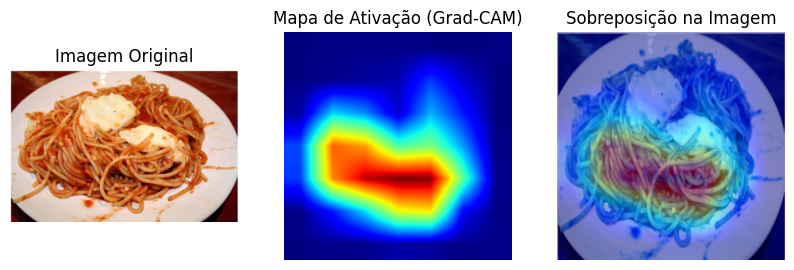

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Função para aplicar o Grad-CAM
def grad_cam(model, image_path, target_layer, transform, device):
    model.eval()

    # Carregar e processar a imagem
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Criar um hook para capturar os gradientes
    gradients = None
    activations = None

    def save_gradients(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    def save_activations(module, input, output):
        nonlocal activations
        activations = output

    # Registrar hooks na camada alvo
    handle_activation = target_layer.register_forward_hook(save_activations)
    handle_gradient = target_layer.register_backward_hook(save_gradients)

    # Forward pass
    output = model(image_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backward pass para obter os gradientes da classe prevista
    model.zero_grad()
    one_hot_output = torch.zeros_like(output).to(device)
    one_hot_output[0, pred_class] = 1
    output.backward(gradient=one_hot_output)

    # Remover hooks
    handle_activation.remove()
    handle_gradient.remove()

    # Calcular Grad-CAM
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * activations, dim=1).squeeze().cpu().detach().numpy()
    cam = np.maximum(cam, 0)  # ReLU para remover valores negativos
    cam = cv2.resize(cam, (224, 224))  # Redimensionar para o tamanho original

    # Normalizar Grad-CAM
    cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))

    # Converter a imagem para exibição
    image_np = np.array(image.resize((224, 224)))
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

    # Sobrepor Grad-CAM na imagem original
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

    # Mostrar os resultados
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Imagem Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap="jet")
    plt.title("Mapa de Ativação (Grad-CAM)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Sobreposição na Imagem")
    plt.axis("off")

    plt.show()

# Definir a camada alvo (última camada convolucional do EfficientNet-B0)
target_layer = model_effnet.features[-1]

# Caminho para uma imagem de teste
image_path = "/content/drive/MyDrive/MyFoodDataset/test/spaghetti/spaghetti_107.png"

# Executar Grad-CAM
grad_cam(model_effnet, image_path, target_layer, data_transforms["test"], device)


# T-SNE e PCA

Essas técnicas reduzem a dimensionalidade dos dados e ajudam a visualizar como o modelo organiza as classes.

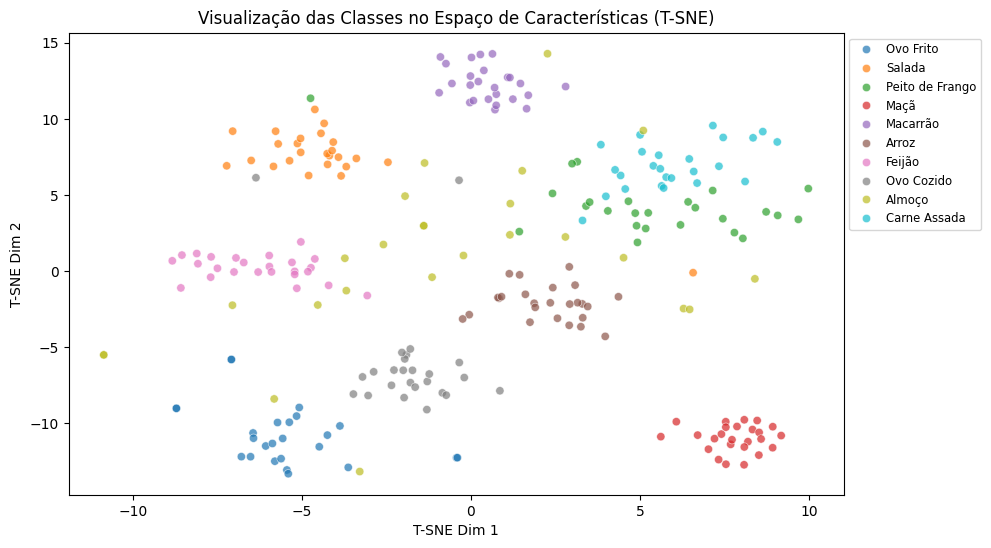

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def extract_features(model, dataloader, device):
    model.eval()
    features, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Extraindo a penúltima camada (antes da classificação)
            feat = model.features(inputs)
            feat = torch.flatten(feat, start_dim=1)  # Achatar para um vetor

            features.append(feat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels_list = np.concatenate(labels_list, axis=0)

    return features, labels_list

# Extrai os embeddings do modelo
features, labels = extract_features(model_effnet, dataloaders['test'], device)

# PCA para redução de dimensionalidade inicial
pca = PCA(n_components=50)
features_pca = pca.fit_transform(features)

# Aplicar T-SNE para visualizar em 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Criar o gráfico
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_tsne[:, 0], y=features_tsne[:, 1], hue=[class_names[i] for i in labels], palette="tab10", alpha=0.7)
plt.xlabel("T-SNE Dim 1")
plt.ylabel("T-SNE Dim 2")
plt.title("Visualização das Classes no Espaço de Características (T-SNE)")
plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1, 1))
plt.show()


Cada ponto no gráfico → Representa uma imagem processada pelo modelo.

Cores diferentes → Cada classe de comida recebe uma cor única.

Agrupamentos bem definidos → Indicando que o modelo consegue separar bem as classes.

Se houver sobreposição → Algumas classes podem ser semelhantes entre si e mais difíceis de distinguir(lunch por exemplo).